# Imports

In [1]:
import shap
import optuna

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy      import stats
from sklearn    import metrics
from lightgbm   import LGBMRegressor

from BorutaShap import BorutaShap

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SelectFromModel

/home/junior/.pyenv/versions/3.9.17/envs/datascience_toolkit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [2]:
random_state = 42
np.random.seed(random_state)

pd.options.display.max_columns = None
pd.options.display.max_rows = 2000

In [3]:
def get_dimensions(df):

    print("Number of Rows: {}".format(df.shape[0]))
    print("NUmber of Cols: {}".format(df.shape[1]))

# Loading Datasets

In [4]:
X, y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)
df = pd.concat([X, y], axis=1)

X = df.drop(columns='target')
y = df.loc[:, ['target']]

# Machine Learning

## LightGBM CV

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
def get_regression_metrics(y, col_target='target', col_pred='pred', decimals=0):

    """
    Function to calculate the regression metrics: R2, RMSE, MAE, MAPE, MedAE

    Parameters
    ----------
    y : DataFrame
        Data frame with target and prediction.

    col_target : str
        The name of the columns with the target.

    col_pred : str
        The name of the columns with the prediction.

    decimals : int
        Number of decimal places to round.
    
    Returns
    -------
    dict_results : Dict
        Dictionary with metric results.
    """

    r2 = metrics.r2_score(y[col_target], y[col_pred])

    rmse = metrics.root_mean_squared_error(y[col_target], y[col_pred])

    mae = metrics.mean_absolute_error(y[col_target], y[col_pred])

    mape = metrics.mean_absolute_percentage_error(y[col_target], y[col_pred])

    medae = metrics.median_absolute_error(y[col_target], y[col_pred])

    dict_results = {
        "R2": np.round(r2, decimals), "RMSE": np.round(rmse, decimals), 
        "MAE": np.round(mae, decimals), "MAPE": np.round(mape, decimals), "MedAE": np.round(medae, decimals)}

    return dict_results

In [7]:
def select_from_model(estimator, X_train, y_train, target='target', threshold=None, max_features=None):

    sfm = SelectFromModel(estimator, threshold=None, max_features=None)
    sfm.fit(X_train, y_train[target])

    list_selected_features = X_train.loc[:, sfm.get_support()].columns.tolist()

    return list_selected_features

In [8]:
def fit_lightgbm_regressor_cv(X_train, y_train, X_test, y_test, target, cv=3, params=None, random_state=42):

    cat_columns = X_train.select_dtypes(include='object')

    if any(cat_columns):

        print('---------------> Feature Engineering')
        
        X_train[cat_columns] = X_train[cat_columns].astype("category")
        X_test[cat_columns] = X_test[cat_columns].astype("category")

    print('---------------> Modeling')

    init_params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'random_state': random_state, "bagging_freq": 1, 'n_jobs': -1}
    
    if params:
        
        params.update(**init_params)
        model = LGBMRegressor(**params)
    
    else:

        model = LGBMRegressor(**init_params)
    
    cv_results = cross_validate(
        estimator=model, X=X_train, y=y_train['target'], cv=3,
        scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_median_absolute_error', 'neg_mean_absolute_percentage_error'])

    r2_mean = np.round(cv_results['test_r2'].mean(), 2)
    mae_mean = np.round(cv_results['test_neg_mean_absolute_error'].mean() * -1, 2)
    rmse_mean = np.round(cv_results['test_neg_root_mean_squared_error'].mean() * -1, 2)
    medae_mean = np.round(cv_results['test_neg_median_absolute_error'].mean() * -1, 2)
    mape_mean = np.round(cv_results['test_neg_mean_absolute_percentage_error'].mean() * -1, 2)

    model.fit(X_train, y_train[target])
    y_test['pred'] = model.predict(X_test)

    dict_results = get_regression_metrics(y_test, target, decimals=2)
    
    r2, mae, rmse, mape, medae = dict_results['R2'], dict_results['MAE'], dict_results['RMSE'], dict_results['MAPE'], dict_results['MedAE']

    print('---------------> Metrics')

    print(f"Cross Validation  R2: {r2_mean}, MAE: {mae_mean}, RMSE: {rmse_mean}, MAPE: {mape_mean}, MedAE: {medae_mean}")
    print(f"Test  Validation  R2: {r2}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}, MedAE: {medae}")

In [9]:
def boruta_shap_regression(
        X_train, y_train, model=None, target='target', n_trials=100, sample=False, train_or_test='test', normalize=True, verbose=False):
    
    boruta_shap = BorutaShap(model, importance_measure='shap', classification=False)
    boruta_shap.fit(
        X=X_train, y=y_train[target], n_trials=n_trials, sample=sample, 
        train_or_test=train_or_test, normalize=normalize, verbose=verbose)

    list_selected_features = boruta_shap.Subset().columns.tolist()
    
    return list_selected_features

In [10]:
def do_lightgbm_regression_param_tuning_cv(
    X_train, y_train, selected_features, n_trials=100, target='target', scoring='r2', direction='maximize'):
    
    def objective(trial):
    
        param = {
            "objective": "regression",
            "metric": "rmse",
            "verbosity": -1,
            "bagging_freq": 1,
            "n_jobs": -1,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
        }
        
        cv_results = cross_validate(
            estimator=LGBMRegressor(**param), 
            scoring=scoring, cv=3,
            X=X_train[selected_features], y=y_train[target])
    
        score_mean = cv_results['test_score'].mean()
    
        return score_mean
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params

In [11]:
def get_tree_feature_importance(model, X_train):
    
    df_imp = pd.DataFrame(model.feature_importances_, X_train.columns).reset_index()
    df_imp.columns = ["Variable", "Importance"]
    df_imp = df_imp.sort_values("Importance", ascending=False)
    
    sns.barplot(x="Importance", y="Variable", color="#006e9cff", data=df_imp[:20])
    
    plt.title(f"Importance of Variables")
    plt.show()

    return df_imp

In [12]:
def get_tree_shap_values(model, X_train):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train)

In [13]:
def automodeling_lightgbm_regressor_cv(
    X_train, y_train, X_test, y_test, selection_method='sfm', target='target', cv=3, n_trials=100, scoring='r2', direction='maximize'):

    print('--------> Standard Model')

    fit_lightgbm_regressor_cv(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target=target, cv=cv)

    print()
    print('--------> Feature Selection')

    if selection_method == 'sfm':

        print('---------------> Select From Model')
        
        list_selected_features = select_from_model(
            estimator=LGBMRegressor(verbosity=-1, random_state=42, n_jobs=-1), X_train=X_train, y_train=y_train, target=target)

    elif selection_method == 'boruta':

        print('---------------> Boruta Shap')

        list_selected_features = boruta_shap_regression(
            X_train=X_train, y_train=y_train, model=LGBMRegressor(verbosity=-1, random_state=42, n_jobs=-1), 
            n_trials=100, sample=False, train_or_test='test', normalize=True, verbose=False)

    else:

        list_selected_features = X_train.columns.tolist()
    
    fit_lightgbm_regressor_cv(
        X_train=X_train[list_selected_features], y_train=y_train, 
        X_test=X_test[list_selected_features], y_test=y_test, target=target, cv=cv)

    print()
    print('--------> Hyperparameter Tuning')
    params = do_lightgbm_regression_param_tuning_cv(
        X_train, y_train, list_selected_features, n_trials=n_trials, target='target', scoring=scoring, direction=direction)
    
    fit_lightgbm_regressor_cv(
        X_train=X_train[list_selected_features], y_train=y_train, 
        X_test=X_test[list_selected_features], y_test=y_test, target='target', cv=cv, params=params)

    print()
    print('--------> Final Modeling')
    model = LGBMRegressor(**params)
    model.fit(X_train[list_selected_features], y_train[target])

    print()
    print('--------> Feature Importance')
    df_imp = get_tree_feature_importance(model, X_train[list_selected_features])

    print()
    print('--------> Shap Values')
    get_tree_shap_values(model, X_train[list_selected_features])
    
    return model, df_imp

--------> Standard Model
---------------> Modeling
---------------> Metrics
Cross Validation  R2: 0.38, MAE: 47.74, RMSE: 59.92, MAPE: 0.43, MedAE: 41.96
Test  Validation  R2: 0.51, MAE: 43.37, RMSE: 54.51, MAPE: 0.36, MedAE: 39.1

--------> Feature Selection
---------------> Boruta Shap


100%|██████████| 100/100 [00:03<00:00, 25.33it/s]


---------------> Modeling
---------------> Metrics
Cross Validation  R2: 0.33, MAE: 50.57, RMSE: 62.63, MAPE: 0.45, MedAE: 45.31
Test  Validation  R2: 0.42, MAE: 47.16, RMSE: 59.55, MAPE: 0.4, MedAE: 37.37

--------> Hyperparameter Tuning
---------------> Modeling
---------------> Metrics
Cross Validation  R2: 0.42, MAE: 48.06, RMSE: 58.18, MAPE: 0.43, MedAE: 45.12
Test  Validation  R2: 0.59, MAE: 39.18, RMSE: 49.98, MAPE: 0.35, MedAE: 28.74

--------> Final Modeling

--------> Feature Importance


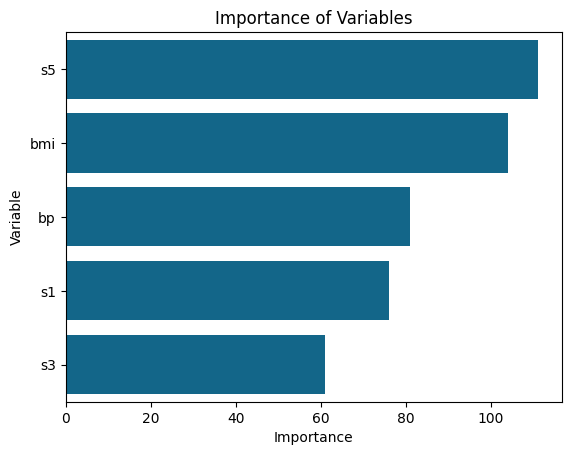


--------> Shap Values


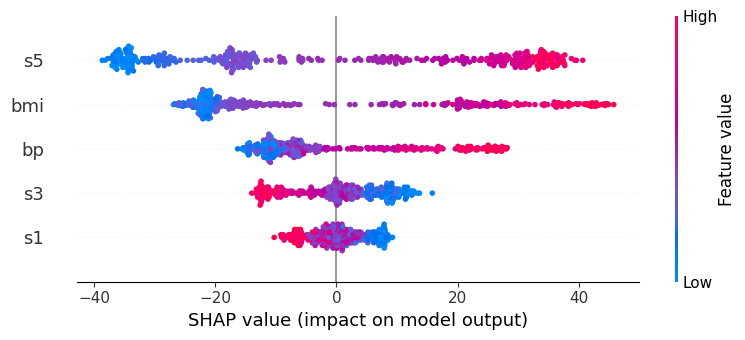

CPU times: user 4min 41s, sys: 1.91 s, total: 4min 43s
Wall time: 38.9 s


In [14]:
%%time
model, df_imp = automodeling_lightgbm_regressor_cv(X_train, y_train, X_test, y_test, selection_method='boruta', target='target', cv=3, n_trials=500)

--------> Standard Model
---------------> Modeling
---------------> Metrics
Cross Validation  R2: 0.38, MAE: 47.74, RMSE: 59.92, MAPE: 0.43, MedAE: 41.96
Test  Validation  R2: 0.51, MAE: 43.37, RMSE: 54.51, MAPE: 0.36, MedAE: 39.1

--------> Feature Selection
---------------> Select From Model
---------------> Modeling
---------------> Metrics
Cross Validation  R2: 0.35, MAE: 49.15, RMSE: 61.63, MAPE: 0.43, MedAE: 41.84
Test  Validation  R2: 0.41, MAE: 47.22, RMSE: 60.28, MAPE: 0.39, MedAE: 45.58

--------> Hyperparameter Tuning
---------------> Modeling
---------------> Metrics
Cross Validation  R2: 0.43, MAE: 47.91, RMSE: 57.87, MAPE: 0.43, MedAE: 43.59
Test  Validation  R2: 0.56, MAE: 41.72, RMSE: 51.74, MAPE: 0.37, MedAE: 29.88

--------> Final Modeling

--------> Feature Importance


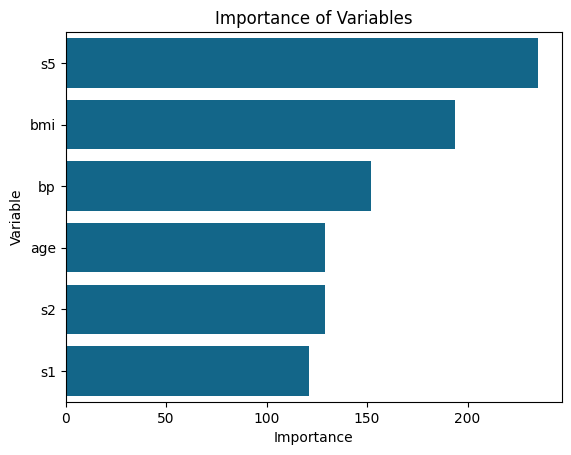


--------> Shap Values


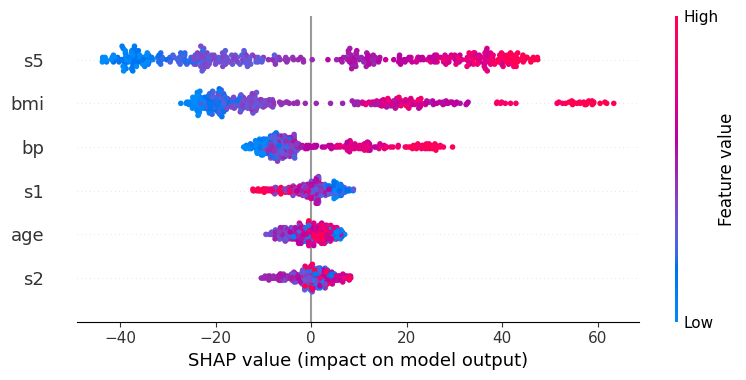

CPU times: user 5min 8s, sys: 2.07 s, total: 5min 10s
Wall time: 38.9 s


In [15]:
%%time
model, df_imp = automodeling_lightgbm_regressor_cv(X_train, y_train, X_test, y_test, selection_method='sfm', target='target', cv=3, n_trials=500)